In [ ]:
#import libraries needed
import numpy as np
import PIL.Image
import time
import functools
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
firstpic_path = tf.keras.utils.get_file("Technological_Institute_of_the_Philippines_Quezon_City.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Technological_Institute_of_the_Philippines_Quezon_City.jpg/220px-Technological_Institute_of_the_Philippines_Quezon_City.jpg")
picstyle_path = tf.keras.utils.get_file("7K6HiiH.jpeg", "https://i.imgur.com/7K6HiiH.jpeg")

In [ ]:
def load_img(path_to_image):
  max_dim = 512
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  return image

In [ ]:
def imshow(picture, title=None):
  if len(picture.shape) > 3:
    picture = tf.squeeze(picture, axis=0)

  plt.imshow(picture)
  if title:
    plt.title(title)

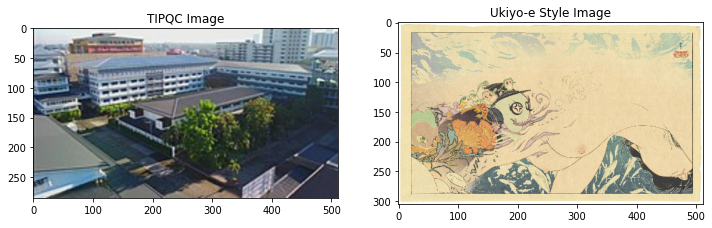

In [ ]:
tipqc_image = load_img(firstpic_path)
ukiyoe_image = load_img(picstyle_path)

plt.subplot(1, 2, 1)
imshow(tipqc_image, 'TIPQC Image')

plt.subplot(1, 2, 2)
imshow(ukiyoe_image, 'Ukiyo-e Style Image')

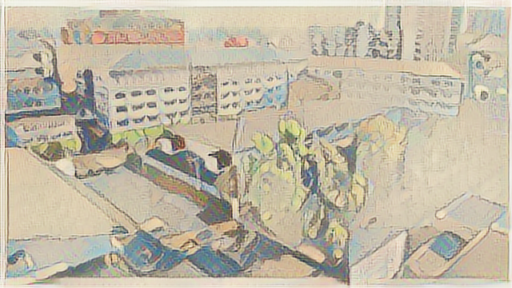

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
ukiyoe_styled_image = hub_model(tf.constant(tipqc_image), tf.constant(ukiyoe_image))[0]
tensor_to_image(ukiyoe_styled_image)

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(tipqc_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top5]

[('dock', 0.27049798),
 ('solar_dish', 0.05459464),
 ('pier', 0.047435246),
 ('dam', 0.04540412),
 ('liner', 0.035428494)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [ ]:
tipqc_layers = ['block5_conv2'] 

ukiyoe_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_tipqc_layers = len(tipqc_layers)
num_ukiyoe_layers = len(ukiyoe_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(ukiyoe_layers)
style_outputs = style_extractor(ukiyoe_image*255)

#Look at the statistics of each layer's output
for name, output in zip(ukiyoe_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 305, 512, 64)
  min:  0.0
  max:  876.13245
  mean:  36.554165

block2_conv1
  shape:  (1, 152, 256, 128)
  min:  0.0
  max:  3407.4485
  mean:  190.40868

block3_conv1
  shape:  (1, 76, 128, 256)
  min:  0.0
  max:  10866.469
  mean:  167.56929

block4_conv1
  shape:  (1, 38, 64, 512)
  min:  0.0
  max:  20412.746
  mean:  697.3616

block5_conv1
  shape:  (1, 19, 32, 512)
  min:  0.0
  max:  3145.4858
  mean:  54.03276



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, ukiyoe_layers, tipqc_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(ukiyoe_layers + tipqc_layers)
    self.style_layers = ukiyoe_layers
    self.content_layers = tipqc_layers
    self.num_style_layers = len(ukiyoe_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(ukiyoe_layers, tipqc_layers)

results = extractor(tf.constant(tipqc_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.010115863
    max:  16815.094
    mean:  481.76944

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  109951.5
    mean:  15010.537

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  347432.4
    mean:  13992.303

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4010766.5
    mean:  197070.8

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  82825.75
    mean:  1402.5009

Contents:
   block5_conv2
    shape:  (1, 17, 31, 512)
    min:  0.0
    max:  773.9879
    mean:  14.19923


In [ ]:
style_targets = extractor(ukiyoe_styled_image)['style']
content_targets = extractor(tipqc_image)['content']

In [ ]:
image = tf.Variable(tipqc_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
ukiyoe_weight=1e-2
tipqc_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    ukiyoe_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    ukiyoe_loss *= ukiyoe_weight / num_ukiyoe_layers

    tipqc_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    tipqc_loss *= tipqc_weight / num_tipqc_layers
    loss = ukiyoe_loss + tipqc_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

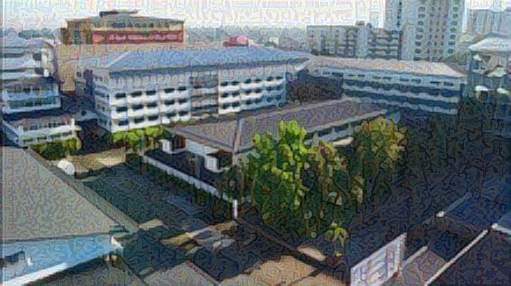

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

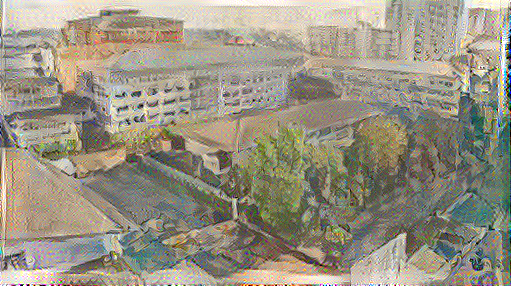

Train step: 1000
Total time: 3381.0


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

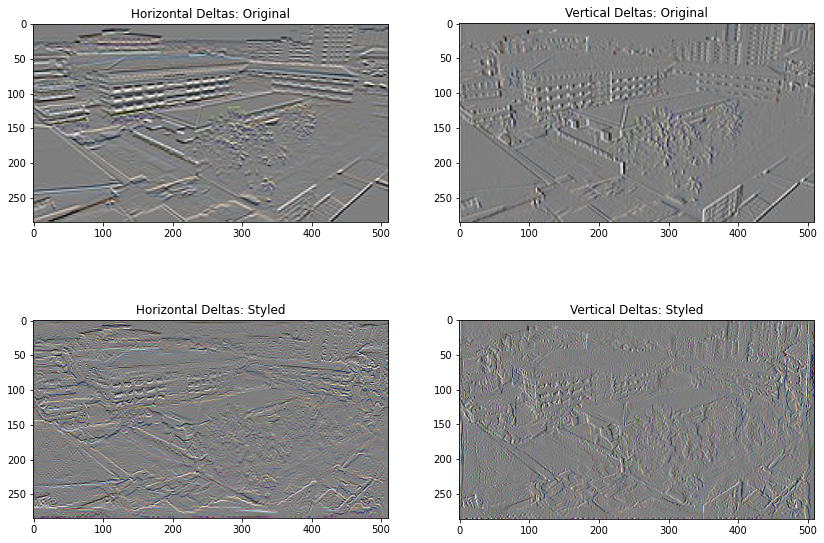

In [ ]:
x_deltas, y_deltas = high_pass_x_y(tipqc_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")


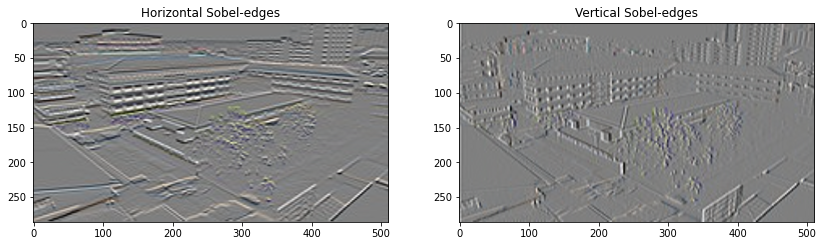

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(tipqc_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

78745.89

In [ ]:
tf.image.total_variation(image).numpy()

array([78745.89], dtype=float32)

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(tipqc_image)

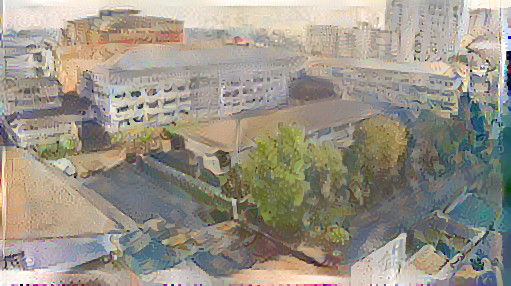

Train step: 1000
Total time: 3421.4


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'tipqc_ukiyo-e_styled_image.jpg'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>